# Analysing Adult Data

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import ttest_ind
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
from datetime import timedelta

### Loading the datasets

In [2]:
adults = pd.read_csv("data_adults.csv")
df_weighted = pd.read_csv("weight_subcat.csv")
#df_weighted = pd.read_csv("df_delete.csv")

Session 1 scores will be taken as the baseline scores. First, we wish to check the relationship of the baseline scores with the hair and saliva cortisol levels. Second, we would be checking the predictive relationship of baseline subluxation levels and the hair and saliva cortisol levels. We will assume baseline subluxation as the independent variable, and the hair and saliva cortisol levels as the dependent variables.

we will also extract the subluxation scores for each patient's last session and will create a new column with these values. These will act as the subluxation scores after the 12 week intervention.

In [3]:
# Step 1: Select only columns containing "Weighted Sum"
weighted_sum_cols = [col for col in adults.columns if "Weighted Sum" in col]

# Step 2: Get the last non-zero value in each row from selected columns
adults['Last Intervention Score'] = adults[weighted_sum_cols].apply(
    lambda row: row[row != 0].dropna().iloc[-1] if (row[row != 0].dropna().size > 0) else None, axis=1
)

# Step 3: Extract session time columns (excluding Weighted Sum ones)
time_cols = [col for col in adults.columns if col.startswith('Session') and 'Weighted Sum' not in col]

# Step 4: Convert session time strings to datetime (ISO format like '2022-04-22 13:50:00')
df_time = adults[time_cols].apply(pd.to_datetime, errors='coerce')

# Step 5: Get the first session date per row
first_session = df_time.min(axis=1)

# Step 6: Initialize the new column
adults['Mid Intervention Score'] = None

# Step 7: Loop to extract the score 42 days after the first session
for idx in adults.index:
    base_date = first_session.loc[idx]
    if pd.isnull(base_date):
        continue

    # Target is 42 days after base
    target_date = base_date + timedelta(days=42)

    # Get session columns on or after this date
    session_times = df_time.loc[idx]
    future_sessions = session_times[session_times >= target_date].sort_values()

    if not future_sessions.empty:
        session_col = future_sessions.index[0]  # Get first session after 42 days
        weighted_sum_col = session_col + ' Weighted Sum'

        if weighted_sum_col in df_weighted.columns:
            adults.at[idx, 'Mid Intervention Score'] = adults.at[idx, weighted_sum_col]

# Resulting DataFrame
adults

,Unnamed: 0,ID,Enrolment Date,Initial Care Plan,Age Group,Active/Passive,Session 1,Session 1 Weighted Sum,Session 1 Cervical,Session 1 Lumbar,...,Depression_Baseline,Depression_Week 12,Depression_Week 16,Depression_Week 6,Stress_Baseline,Stress_Week 12,Stress_Week 16,Stress_Week 6,Last Intervention Score,Mid Intervention Score
0,0.0,1,20/4,3x4,Adults,Active,2022-04-20 14:00:00,26.0,15.0,2.0,...,8.5,8.5,5.0,9.0,11.0,6.0,7.0,13.0,10.0,26.0
1,1.0,2,20/4,3x4,Adults,Active,2022-04-20 12:35:00,19.0,8.0,3.0,...,7.0,0.0,0.0,5.0,8.0,1.0,1.0,9.0,16.0,19.0
2,2.0,4,19/4,3x4,Adults,Active,2022-04-19 12:55:00,17.0,9.0,0.0,...,1.0,NaN,NaN,0.0,2.0,NaN,NaN,0.0,12.0,17.0
3,3.0,5,21/4,3x4,Adults,Active,2022-04-21 12:35:00,25.0,13.0,5.0,...,0.0,5.0,0.0,0.0,2.0,9.0,0.0,0.0,12.0,25.0
4,4.0,6,20/4,3x4,Adults,Active,2022-04-20 13:40:00,24.0,15.0,2.0,...,7.0,10.0,4.0,4.0,11.0,9.0,4.0,9.0,17.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,192.0,217,NaN,2x6,Adults,Passive,2022-06-02 10:35:00,23.0,13.0,0.0,...,3.0,0.0,1.0,0.0,5.0,0.0,1.0,1.0,31.0,23.0
119,193.0,220,NaN,2x6,Adults,Passive,2022-06-02 10:28:00,24.0,13.0,0.0,...,2.0,0.0,NaN,NaN,3.5,0.0,NaN,NaN,22.0,24.0
120,194.0,221,2022-09-06 00:00:00,NaN,Adults,Passive,NaT,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,21.0
121,195.0,223,2022-09-06 00:00:00,NaN,Adults,Passive,2022-06-09 08:44:00,22.0,15.0,0.0,...,0.0,NaN,1.0,0.0,0.0,NaN,2.0,1.0,25.0,22.0


### Correlation between the variables

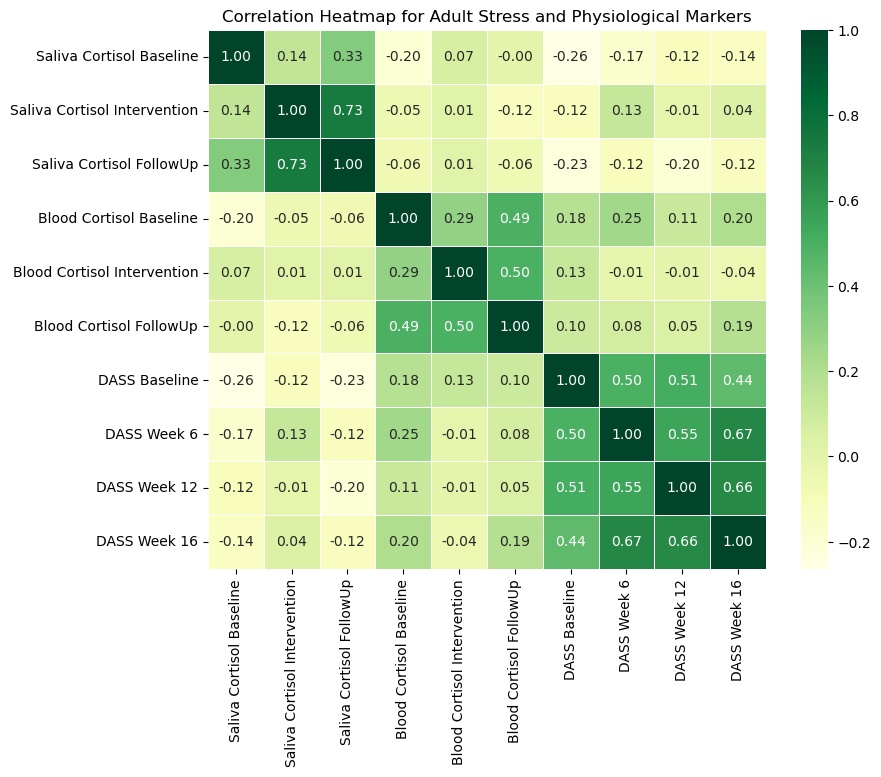

In [4]:
# Select specific columns
columns_to_plot = [ 
                   "Saliva Cortisol Baseline", "Saliva Cortisol Intervention", "Saliva Cortisol FollowUp", 
                   "Blood Cortisol Baseline", "Blood Cortisol Intervention", "Blood Cortisol FollowUp", "DASS Baseline", "DASS Week 6", "DASS Week 12", "DASS Week 16"]  
corr_matrix = adults[columns_to_plot].corr(method='spearman')

# Create a heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(corr_matrix, annot=True, cmap="YlGn", fmt=".2f", linewidths=0.5)

# Add title
plt.title("Correlation Heatmap for Adult Stress and Physiological Markers")
plt.show()

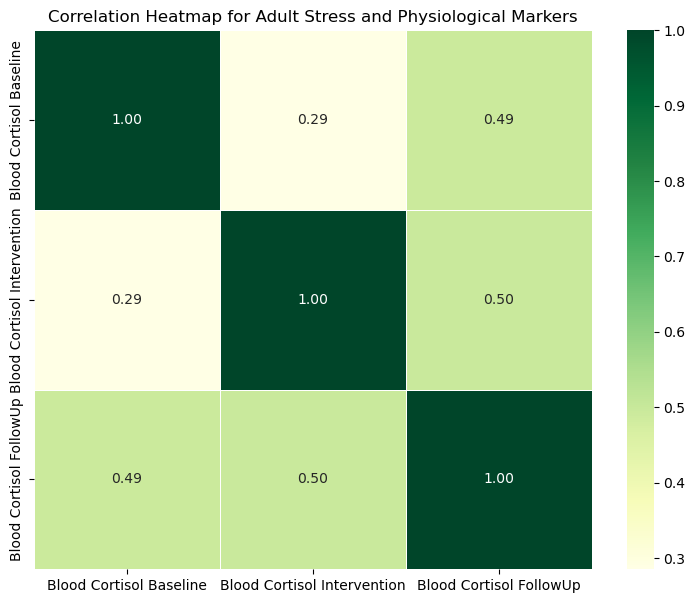

In [5]:
# Select specific columns
columns_to_plot = [
                   "Blood Cortisol Baseline", "Blood Cortisol Intervention", "Blood Cortisol FollowUp"]  
corr_matrix = adults[columns_to_plot].corr(method='spearman')

# Create a heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(corr_matrix, annot=True, cmap="YlGn", fmt=".2f", linewidths=0.5)

# Add title
plt.title("Correlation Heatmap for Adult Stress and Physiological Markers")
plt.show()

In [6]:
import numpy as np

# Assuming your DataFrame is called df and the column to transform is 'your_variable'
adults['BloodBaseline_log'] = np.log(adults['Blood Cortisol Baseline'] + 1)
adults['BloodPost_log'] = np.log(adults['Blood Cortisol Intervention'] + 1)
adults['BloodFollow_log'] = np.log(adults['Blood Cortisol FollowUp'] + 1)
adults['SalivaBaseline_log'] = np.log(adults['Saliva Cortisol Baseline'] + 1)
adults['SalivaFollow_log'] = np.log(adults['Saliva Cortisol FollowUp'] + 1)
adults['SalivaPost_log'] = np.log(adults['Saliva Cortisol Intervention'] + 1)
adults['DASSBaseline_log'] = np.log(adults['DASS Baseline'] + 1)
adults['DASSWeek6_log'] = np.log(adults['DASS Week 6'] + 1)
adults['DASSWeek12_log'] = np.log(adults['DASS Week 12'] + 1)
adults['DASSWeek16_log'] = np.log(adults['DASS Week 16'] + 1)
adults['LastScore_log'] = np.log(adults['Last Intervention Score'] + 1)


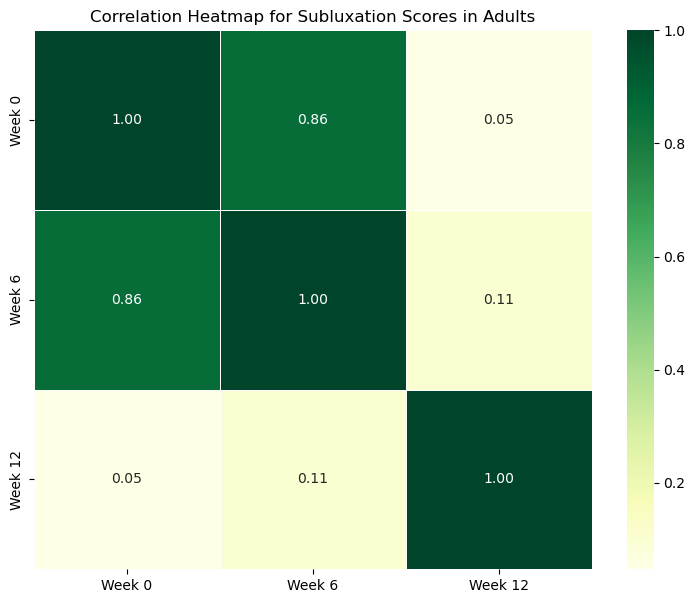

In [7]:
# Select and rename columns for display
columns_to_plot = [
    "Session 1 Weighted Sum",  
    "Mid Intervention Score",
    "Last Intervention Score"
]

# Compute correlation matrix
corr_matrix = adults[columns_to_plot].corr()

# Rename for heatmap display
display_labels = {
    "Session 1 Weighted Sum": "Week 0",
    "Mid Intervention Score": "Week 6",
    "Last Intervention Score": "Week 12"
}

# Apply new labels
corr_matrix.rename(index=display_labels, columns=display_labels, inplace=True)

# Create a heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(corr_matrix, annot=True, cmap="YlGn", fmt=".2f", linewidths=0.5)

# Add title
plt.title("Correlation Heatmap for Subluxation Scores in Adults")
plt.show()

In [8]:
# Fill missing values
adults_filled = adults.fillna(0)

# Step 2: Encode Active/Passive
adults_filled['Active_Passive_Encoded'] = adults_filled['Active/Passive'].map({'Passive': 0, 'Active': 1})
adults_filled['Active_Passive_Encoded'] = adults_filled['Active_Passive_Encoded'].fillna(0)

adults_filled = adults_filled[adults_filled["Active/Passive"] != 0]
print(adults_filled["Active/Passive"].value_counts())

Active/Passive
Active     64
Passive    58
Name: count, dtype: int64


In [9]:
# 2. Rename columns
adults_filled = adults_filled.rename(columns={
    "Last Intervention Score": "Last_Intervention_Score",
    "Active/Passive":  "ActivePassive",
    "Mid Intervention Score": "Mid_Intervention_Score",
    "Saliva Cortisol Baseline": "Saliva_Cortisol_Baseline",
    "Anxiety_Baseline": "Anxiety_Baseline",
    "Anxiety_Week 6": "Anxiety_Week_6",
    "Anxiety_Week 12": "Anxiety_Week_12",
    "Stress_Baseline": "Stress_Baseline",
    "Stress_Week 6": "Stress_Week_6",
    "Stress_Week 12": "Stress_Week_12",
    "DASS Baseline": "DASS_Baseline",
    "DASS Week 6": "DASS_Week_6"

})

## Log Transformed

In [10]:
import numpy as np

# Assuming your DataFrame is called df and the column to transform is 'your_variable'
adults_filled['BloodBaseline_log'] = np.log(adults_filled['Blood Cortisol Baseline'] + 1)
adults_filled['BloodPost_log'] = np.log(adults_filled['Blood Cortisol Intervention'] + 1)
adults_filled['SalivaBaseline_log'] = np.log(adults_filled['Saliva_Cortisol_Baseline'] + 1)
adults_filled['SalivaPost_log'] = np.log(adults_filled['Saliva Cortisol Intervention'] + 1)
adults_filled['DASSBaseline_log'] = np.log(adults_filled['DASS_Baseline'] + 1)
#adults_filled['LastScore_log'] = np.log(adults_filled['Last_Intervention_Score'] + 1)
#adults_filled['MidScore_log'] = np.log(adults_filled['Mid_Intervention_Score'] + 1)

In [11]:
import pandas as pd
import statsmodels.formula.api as smf

# Original dataset
df = adults_filled.copy()

# ----------------------------
# 1. Melt score and time columns
# ----------------------------
score_cols = [f"Session {i} Weighted Sum" for i in range(1, 37)]
time_cols = [f"Session {i}" for i in range(1, 37)]

# Melt scores
df_scores = df[["ID"] + score_cols].melt(id_vars="ID", var_name="Session", value_name="Score")
df_scores["SessionNum"] = df_scores["Session"].str.extract("(\d+)").astype(int)

# Melt times
df_times = df[["ID"] + time_cols].melt(id_vars="ID", var_name="Session", value_name="Timestamp")
df_times["SessionNum"] = df_times["Session"].str.extract("(\d+)").astype(int)
df_times["Timestamp"] = df_times["Timestamp"].astype(str).str.strip()
df_times["Timestamp"] = df_times["Timestamp"].replace(["0", "", "nan", "NaT", "None"], pd.NA)
df_times["Timestamp"] = pd.to_datetime(df_times["Timestamp"], errors="coerce")

# Merge scores and times
df_long_scores = pd.merge(df_scores, df_times, on=["ID", "SessionNum"])
df_long_scores = df_long_scores.dropna(subset=["Timestamp"])  # drop missing timestamps

# ----------------------------
# 2. Create long-format cortisol data
# ----------------------------
df_cortisol = pd.concat([
    df.assign(Timepoint="Baseline", BloodCortisol_Long=df["BloodBaseline_log"]),
    df.assign(Timepoint="PostIntervention", BloodCortisol_Long=df["BloodPost_log"])
], ignore_index=True)

df_cortisol = df_cortisol[[
    "ID", "Timepoint", "BloodCortisol_Long", "Last_Intervention_Score", "ActivePassive",
    "Mid_Intervention_Score", "SalivaBaseline_log", "DASSBaseline_log"
]]

# ----------------------------
# 3. Merge cortisol + session timeline data (optional)
# ----------------------------
# If you want to model with session timing as a variable, merge it; else skip
df_final = pd.merge(df_cortisol, df_long_scores[["ID", "Timestamp"]].drop_duplicates("ID"), on="ID", how="left")

# ----------------------------
# 4. Mixed effects model
# ----------------------------
model = smf.mixedlm(
    "BloodCortisol_Long ~ Timepoint + DASSBaseline_log +  C(ActivePassive) + Mid_Intervention_Score+ C(ActivePassive)*Last_Intervention_Score + SalivaBaseline_log",
    df_final,
    groups=df_final["ID"]
)
result = model.fit()
print(result.summary())

                            Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           BloodCortisol_Long
No. Observations:           244               Method:                       REML              
No. Groups:                 122               Scale:                        0.1020            
Min. group size:            2                 Log-Likelihood:               -242.2581         
Max. group size:            2                 Converged:                    Yes               
Mean group size:            2.0                                                               
----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                            0.963    0.614  1.569 0.11

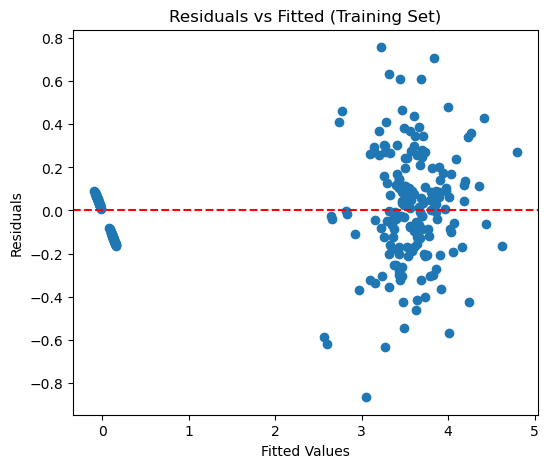

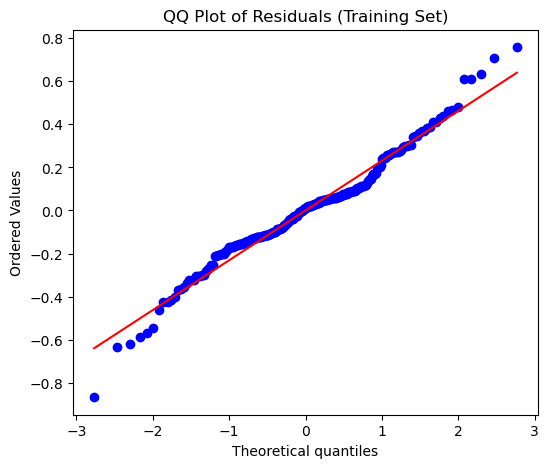

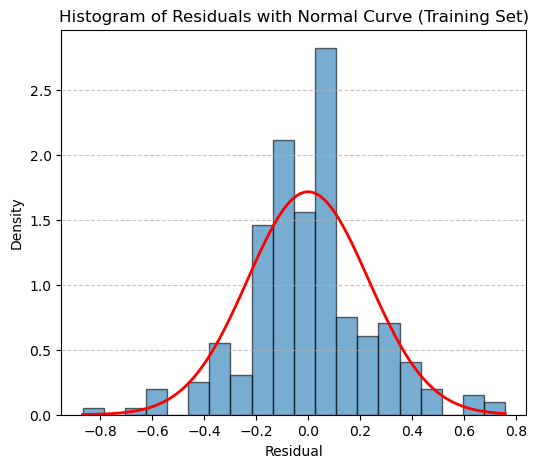

In [12]:
# Predicted values on training data (fitted values)
fitted_vals = result.fittedvalues

# Residuals = Actual - Fitted
residuals = df_final["BloodCortisol_Long"] - fitted_vals

df_final["Fitted"] = fitted_vals
df_final["Residual"] = residuals

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_final["Fitted"], df_final["Residual"])
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Training Set)")
plt.show()

import scipy.stats as stats

plt.figure(figsize=(6, 5))
stats.probplot(df_final["Residual"], dist="norm", plot=plt)
plt.title("QQ Plot of Residuals (Training Set)")
plt.show()

from scipy.stats import norm

# Get mean and std of residuals
mu, std = np.mean(residuals), np.std(residuals)

# Plot histogram
plt.figure(figsize=(6, 5))
count, bins, ignored = plt.hist(residuals, bins=20, density=True, edgecolor='black', alpha=0.6)

# Plot normal distribution curve
x = np.linspace(min(bins), max(bins), 100)
plt.plot(x, norm.pdf(x, mu, std), 'r', linewidth=2)

# Labels and title
plt.title("Histogram of Residuals with Normal Curve (Training Set)")
plt.xlabel("Residual")
plt.ylabel("Density")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [13]:
# Variance of fixed effects predictions
y_fixed = result.fittedvalues  # Predictions using fixed effects
var_fixed = np.var(y_fixed)

# Residual (within-group) variance
var_resid = result.scale

# Random effect variance (between-group)
var_random = result.cov_re.iloc[0, 0]

# Marginal R²: fixed / total
r2_marginal = var_fixed / (var_fixed + var_random + var_resid)

# Conditional R²: (fixed + random) / total
r2_conditional = (var_fixed + var_random) / (var_fixed + var_random + var_resid)

print(f"Marginal R² (fixed effects only): {r2_marginal:.3f}")
print(f"Conditional R² (fixed + random effects): {r2_conditional:.3f}")

Marginal R² (fixed effects only): 0.776
Conditional R² (fixed + random effects): 0.970


In [14]:
import pandas as pd
import statsmodels.formula.api as smf

# Original dataset
df = adults_filled.copy()

# ----------------------------
# 1. Melt score and time columns
# ----------------------------
score_cols = [f"Session {i} Weighted Sum" for i in range(1, 37)]
time_cols = [f"Session {i}" for i in range(1, 37)]

# Melt scores
df_scores = df[["ID"] + score_cols].melt(id_vars="ID", var_name="Session", value_name="Score")
df_scores["SessionNum"] = df_scores["Session"].str.extract("(\d+)").astype(int)

# Melt times
df_times = df[["ID"] + time_cols].melt(id_vars="ID", var_name="Session", value_name="Timestamp")
df_times["SessionNum"] = df_times["Session"].str.extract("(\d+)").astype(int)
df_times["Timestamp"] = df_times["Timestamp"].astype(str).str.strip()
df_times["Timestamp"] = df_times["Timestamp"].replace(["0", "", "nan", "NaT", "None"], pd.NA)
df_times["Timestamp"] = pd.to_datetime(df_times["Timestamp"], errors="coerce")


# Merge scores and times
df_long_scores = pd.merge(df_scores, df_times, on=["ID", "SessionNum"])
df_long_scores = df_long_scores.dropna(subset=["Timestamp"])  # drop missing timestamps

# ----------------------------
# 2. Create long-format cortisol data
# ----------------------------
df_cortisol = pd.concat([
    df.assign(Timepoint="Baseline", BloodCortisol_Long=df["BloodBaseline_log"]),
    df.assign(Timepoint="PostIntervention", BloodCortisol_Long=df["BloodPost_log"])
], ignore_index=True)

df_cortisol = df_cortisol[[
    "ID", "Timepoint", "BloodCortisol_Long", "Last_Intervention_Score", "ActivePassive",
    "Mid_Intervention_Score", "SalivaBaseline_log", "DASSBaseline_log"
]]

# ----------------------------
# 3. Merge cortisol + session timeline data (optional)
# ----------------------------
# If you want to model with session timing as a variable, merge it; else skip
df_final = pd.merge(df_cortisol, df_long_scores[["ID", "Timestamp"]].drop_duplicates("ID"), on="ID", how="left")

# ----------------------------
# 4. Mixed effects model
# ----------------------------
model = smf.mixedlm(
    "BloodCortisol_Long ~ Timepoint + DASSBaseline_log +  C(ActivePassive) + Mid_Intervention_Score + Last_Intervention_Score + SalivaBaseline_log",
    df_final,
    groups=df_final["ID"]
)
result = model.fit()
print(result.summary())

                 Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   BloodCortisol_Long
No. Observations:     244       Method:               REML              
No. Groups:           122       Scale:                0.1020            
Min. group size:      2         Log-Likelihood:       -239.8697         
Max. group size:      2         Converged:            Yes               
Mean group size:      2.0                                               
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      1.067    0.492  2.168 0.030  0.103  2.032
Timepoint[T.PostIntervention]  0.175    0.041  4.278 0.000  0.095  0.255
C(ActivePassive)[T.Passive]    0.275    0.227  1.210 0.226 -0.170  0.720
DASSBaseline_log               0.209    0.062  3.382 0.001  0.088  0.

In [15]:
# Variance of fixed effects predictions
y_fixed = result.fittedvalues  # Predictions using fixed effects
var_fixed = np.var(y_fixed)

# Residual (within-group) variance
var_resid = result.scale

# Random effect variance (between-group)
var_random = result.cov_re.iloc[0, 0]

# Marginal R²: fixed / total
r2_marginal = var_fixed / (var_fixed + var_random + var_resid)

# Conditional R²: (fixed + random) / total
r2_conditional = (var_fixed + var_random) / (var_fixed + var_random + var_resid)

print(f"Marginal R² (fixed effects only): {r2_marginal:.3f}")
print(f"Conditional R² (fixed + random effects): {r2_conditional:.3f}")

Marginal R² (fixed effects only): 0.777
Conditional R² (fixed + random effects): 0.970


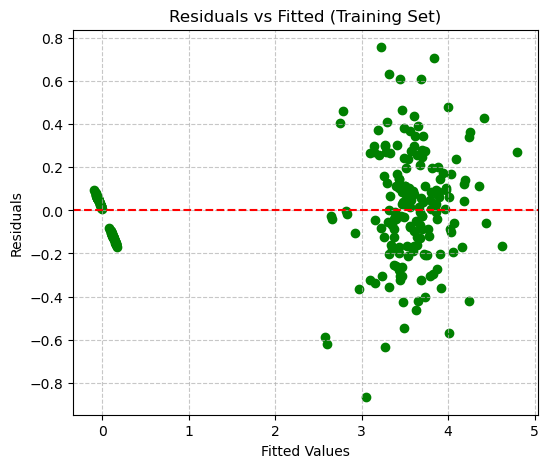

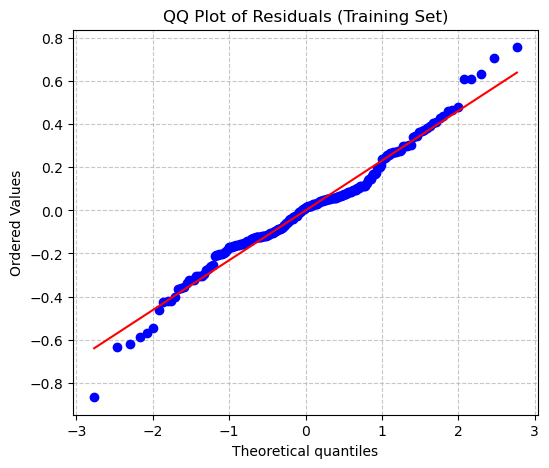

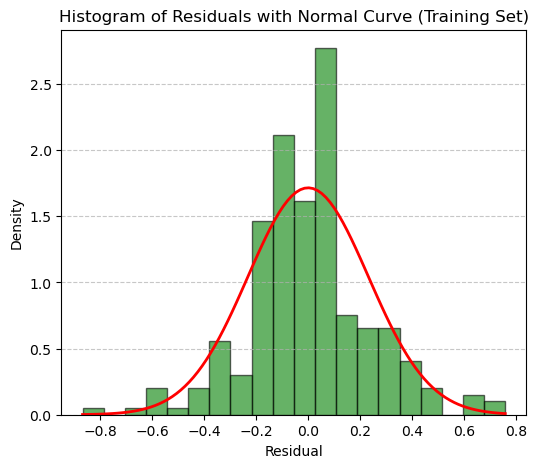

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import norm

# Calculate fitted values and residuals
fitted_vals = result.fittedvalues
residuals = df_final["BloodCortisol_Long"] - fitted_vals

# Store in dataframe
df_final["Fitted"] = fitted_vals
df_final["Residual"] = residuals

# 1. Residuals vs Fitted plot
plt.figure(figsize=(6, 5))
plt.scatter(df_final["Fitted"], df_final["Residual"], color="green")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Training Set)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 2. QQ plot of residuals
plt.figure(figsize=(6, 5))
stats.probplot(df_final["Residual"], dist="norm", plot=plt)
plt.title("QQ Plot of Residuals (Training Set)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 3. Histogram of residuals with normal curve
mu, std = np.mean(residuals), np.std(residuals)

plt.figure(figsize=(6, 5))
count, bins, ignored = plt.hist(residuals, bins=20, density=True,
                                 edgecolor='black', alpha=0.6, color='green')

x = np.linspace(min(bins), max(bins), 100)
plt.plot(x, norm.pdf(x, mu, std), 'r', linewidth=2)

plt.title("Histogram of Residuals with Normal Curve (Training Set)")
plt.xlabel("Residual")
plt.ylabel("Density")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [17]:
import pandas as pd
import statsmodels.formula.api as smf

# Original dataset
df = adults_filled.copy()

# ----------------------------
# 1. Melt score and time columns
# ----------------------------
score_cols = [f"Session {i} Weighted Sum" for i in range(1, 37)]
time_cols = [f"Session {i}" for i in range(1, 37)]

# Melt scores
df_scores = df[["ID"] + score_cols].melt(id_vars="ID", var_name="Session", value_name="Score")
df_scores["SessionNum"] = df_scores["Session"].str.extract("(\d+)").astype(int)

# Melt times
df_times = df[["ID"] + time_cols].melt(id_vars="ID", var_name="Session", value_name="Timestamp")
df_times["SessionNum"] = df_times["Session"].str.extract("(\d+)").astype(int)
df_times["Timestamp"] = df_times["Timestamp"].astype(str).str.strip()
df_times["Timestamp"] = df_times["Timestamp"].replace(["0", "", "nan", "NaT", "None"], pd.NA)
df_times["Timestamp"] = pd.to_datetime(df_times["Timestamp"], errors="coerce")


# Merge scores and times
df_long_scores = pd.merge(df_scores, df_times, on=["ID", "SessionNum"])
df_long_scores = df_long_scores.dropna(subset=["Timestamp"])  # drop missing timestamps

# ----------------------------
# 2. Create long-format cortisol data
# ----------------------------
df_cortisol = pd.concat([
    df.assign(Timepoint="Baseline", BloodCortisol_Long=df["BloodBaseline_log"]),
    df.assign(Timepoint="PostIntervention", BloodCortisol_Long=df["BloodPost_log"])
], ignore_index=True)

df_cortisol = df_cortisol[[
    "ID", "Timepoint", "BloodCortisol_Long", "Last_Intervention_Score", "ActivePassive",
    "Mid_Intervention_Score", "SalivaBaseline_log", "DASSBaseline_log"
]]

# ----------------------------
# 3. Merge cortisol + session timeline data (optional)
# ----------------------------
# If you want to model with session timing as a variable, merge it; else skip
df_final = pd.merge(df_cortisol, df_long_scores[["ID", "Timestamp"]].drop_duplicates("ID"), on="ID", how="left")

# Random slopes for Timepoint within each subject (ID)
model = smf.mixedlm(
    "BloodCortisol_Long ~ Timepoint + DASSBaseline_log + C(ActivePassive) + Mid_Intervention_Score + Last_Intervention_Score + SalivaBaseline_log",
    df_final,
    groups=df_final["ID"],
    re_formula="~Timepoint"
)
result = model.fit()
print(result.summary())

                       Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       BloodCortisol_Long
No. Observations:         244           Method:                   REML              
No. Groups:               122           Scale:                    0.0976            
Min. group size:          2             Log-Likelihood:           -237.9358         
Max. group size:          2             Converged:                Yes               
Mean group size:          2.0                                                       
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                  0.983    0.487  2.020 0.043  0.029  1.936
Timepoint[T.PostIntervention]              0.175    0.041  4.278 0.000  0.095  0.255
C(Ac

C:\Users\Uni\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [18]:
# Variance of fixed effects predictions
y_fixed = result.fittedvalues  # Predictions using fixed effects
var_fixed = np.var(y_fixed)

# Residual (within-group) variance
var_resid = result.scale

# Random effect variance (between-group)
var_random = result.cov_re.iloc[0, 0]

# Marginal R²: fixed / total
r2_marginal = var_fixed / (var_fixed + var_random + var_resid)

# Conditional R²: (fixed + random) / total
r2_conditional = (var_fixed + var_random) / (var_fixed + var_random + var_resid)

print(f"Marginal R² (fixed effects only): {r2_marginal:.3f}")
print(f"Conditional R² (fixed + random effects): {r2_conditional:.3f}")

Marginal R² (fixed effects only): 0.760
Conditional R² (fixed + random effects): 0.972


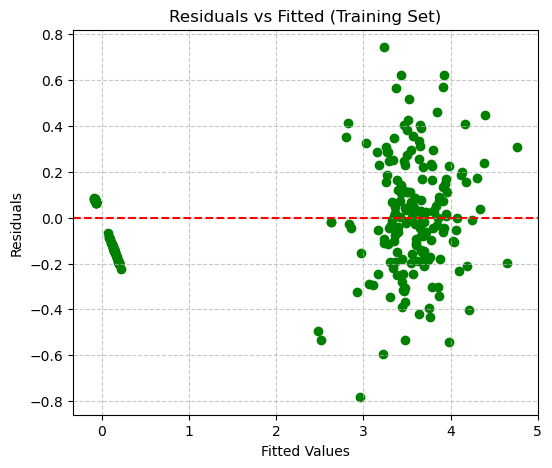

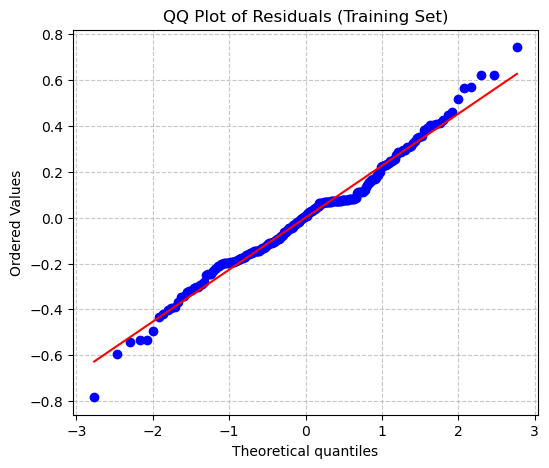

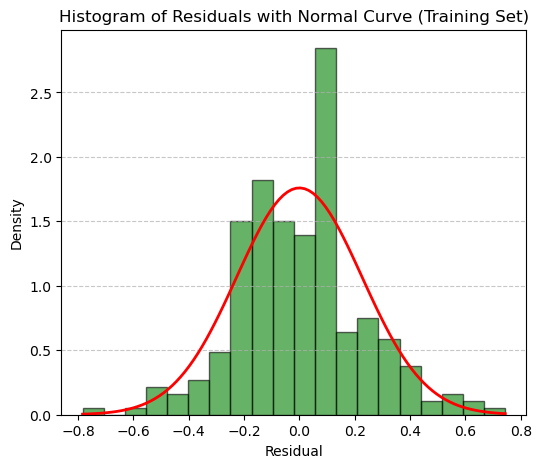

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import norm

# Calculate fitted values and residuals
fitted_vals = result.fittedvalues
residuals = df_final["BloodCortisol_Long"] - fitted_vals

# Store in dataframe
df_final["Fitted"] = fitted_vals
df_final["Residual"] = residuals

# 1. Residuals vs Fitted plot
plt.figure(figsize=(6, 5))
plt.scatter(df_final["Fitted"], df_final["Residual"], color="green")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Training Set)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 2. QQ plot of residuals
plt.figure(figsize=(6, 5))
stats.probplot(df_final["Residual"], dist="norm", plot=plt)
plt.title("QQ Plot of Residuals (Training Set)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 3. Histogram of residuals with normal curve
mu, std = np.mean(residuals), np.std(residuals)

plt.figure(figsize=(6, 5))
count, bins, ignored = plt.hist(residuals, bins=20, density=True,
                                 edgecolor='black', alpha=0.6, color='green')

x = np.linspace(min(bins), max(bins), 100)
plt.plot(x, norm.pdf(x, mu, std), 'r', linewidth=2)

plt.title("Histogram of Residuals with Normal Curve (Training Set)")
plt.xlabel("Residual")
plt.ylabel("Density")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# DASS Scores??

In [49]:
# 2. Rename columns
adults_filled = adults_filled.rename(columns={
    "Last Intervention Score": "Last_Intervention_Score",
    "Active/Passive":  "ActivePassive",
    "Mid Intervention Score": "Mid_Intervention_Score",
    "Saliva Cortisol Baseline": "Saliva_Cortisol_Baseline",
    "Anxiety_Baseline": "Anxiety_Baseline",
    "Anxiety_Week 6": "Anxiety_Week_6",
    "Anxiety_Week 12": "Anxiety_Week_12",
    "Blood Cortisol Baseline": "Blood_Cortisol_Baseline",
    "Stress_Baseline": "Stress_Baseline",
    "Stress_Week 6": "Stress_Week_6",
    "Stress_Week 12": "Stress_Week_12"

})

# Log-Transformed

In [50]:
import numpy as np

# Assuming your DataFrame is called df and the column to transform is 'your_variable'
adults_filled['BloodBaseline_log'] = np.log(adults_filled['Blood_Cortisol_Baseline'] + 1)
adults_filled['BloodPost_log'] = np.log(adults_filled['Blood Cortisol Intervention'] + 1)
adults_filled['SalivaBaseline_log'] = np.log(adults_filled['Saliva_Cortisol_Baseline'] + 1)
adults_filled['SalivaPost_log'] = np.log(adults_filled['Saliva Cortisol Intervention'] + 1)
adults_filled['AnxietyBaseline_log'] = np.log(adults_filled['Anxiety_Baseline'] + 1)
#adults_filled['LastScore_log'] = np.log(adults_filled['Last_Intervention_Score'] + 1)
#adults_filled['MidScore_log'] = np.log(adults_filled['Mid_Intervention_Score'] + 1)
adults_filled['DASSBaseline_log'] = np.log(adults_filled['DASS_Baseline'] + 1)
adults_filled['DASSWeek6_log'] = np.log(adults_filled['DASS_Week_6'] + 1)
adults_filled['DASSPost_log'] = np.log(adults_filled['DASS Week 12'] + 1)

In [51]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# ----------------------------------------
# 1. Setup
# ----------------------------------------
df = adults_filled.copy()

# ----------------------------------------
# 2. Melt timestamps into long format
# ----------------------------------------
time_cols = [f"Session {i}" for i in range(1, 37)]
df_times = df[["ID"] + time_cols].melt(id_vars="ID", var_name="Session", value_name="Timestamp")
df_times["SessionNum"] = df_times["Session"].str.extract("(\d+)").astype(int)
df_times["Timestamp"] = df_times["Timestamp"].astype(str).str.strip()
df_times["Timestamp"] = df_times["Timestamp"].replace(["0", "", "nan", "NaT", "None"], pd.NA)
df_times["Timestamp"] = pd.to_datetime(df_times["Timestamp"], errors="coerce")
df_times = df_times.dropna(subset=["Timestamp"])

# ----------------------------------------
# 3. Compute Days_Since_First
# ----------------------------------------
df_times = df_times.sort_values(by=["ID", "Timestamp"])
df_times["First_Session_Timestamp"] = df_times.groupby("ID")["Timestamp"].transform("min")
df_times["Days_Since_First"] = (df_times["Timestamp"] - df_times["First_Session_Timestamp"]).dt.days

# Keep only what we need
df_session_days = df_times[["ID", "SessionNum", "Days_Since_First"]]

# ----------------------------------------
# 4. Prepare DASS long format
# ----------------------------------------
df_dass = pd.concat([
    df.assign(Timepoint="Baseline", Dass_Long=df["DASSBaseline_log"]),
    df.assign(Timepoint="Week6", Dass_Long=df["DASSWeek6_log"]),
    df.assign(Timepoint="PostIntervention", Dass_Long=df["DASSPost_log"]),
], ignore_index=True)

df_dass = df_dass[[
    "ID", "Timepoint", "Dass_Long", "Last_Intervention_Score", "ActivePassive",
    "Mid_Intervention_Score", "SalivaBaseline_log", "AnxietyBaseline_log", "BloodBaseline_log"
]]

# ----------------------------------------
# 5. Assign closest session by day offset (0, 42, 84)
# ----------------------------------------
# First, merge all session data into one (days since first per ID+session)
def get_closest_session(group, target_day):
    group["Diff"] = abs(group["Days_Since_First"] - target_day)
    return group.loc[group["Diff"].idxmin()]

closest_baseline = df_session_days.groupby("ID").apply(get_closest_session, target_day=0).reset_index(drop=True)
closest_week6 = df_session_days.groupby("ID").apply(get_closest_session, target_day=42).reset_index(drop=True)
closest_week12 = df_session_days.groupby("ID").apply(get_closest_session, target_day=84).reset_index(drop=True)

closest_baseline["Timepoint"] = "Baseline"
closest_week6["Timepoint"] = "Week6"
closest_week12["Timepoint"] = "PostIntervention"

df_timepoints = pd.concat([closest_baseline, closest_week6, closest_week12], ignore_index=True)

# ----------------------------------------
# 6. Merge to assign Days_Since_First to each DASS row
# ----------------------------------------
df_final = pd.merge(df_dass, df_timepoints, on=["ID", "Timepoint"], how="left")

# ----------------------------------------
# 7. Fit Mixed Effects Model
# ----------------------------------------
model = smf.mixedlm(
    "Dass_Long ~ Timepoint + AnxietyBaseline_log + Mid_Intervention_Score + Last_Intervention_Score * C(ActivePassive)",
    df_final,
    groups=df_final["ID"]
)
result = model.fit()
print(result.summary())

                            Mixed Linear Model Regression Results
Model:                         MixedLM              Dependent Variable:              Dass_Long
No. Observations:              366                  Method:                          REML     
No. Groups:                    122                  Scale:                           0.7018   
Min. group size:               3                    Log-Likelihood:                  -518.2908
Max. group size:               3                    Converged:                       Yes      
Mean group size:               3.0                                                            
----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                            1.317    0.482  2.733 0.00

In [52]:
# Variance of fixed effects predictions
y_fixed = result.fittedvalues  # Predictions using fixed effects
var_fixed = np.var(y_fixed)

# Residual (within-group) variance
var_resid = result.scale

# Random effect variance (between-group)
var_random = result.cov_re.iloc[0, 0]

# Marginal R²: fixed / total
r2_marginal = var_fixed / (var_fixed + var_random + var_resid)

# Conditional R²: (fixed + random) / total
r2_conditional = (var_fixed + var_random) / (var_fixed + var_random + var_resid)

print(f"Marginal R² (fixed effects only): {r2_marginal:.3f}")
print(f"Conditional R² (fixed + random effects): {r2_conditional:.3f}")

Marginal R² (fixed effects only): 0.441
Conditional R² (fixed + random effects): 0.611


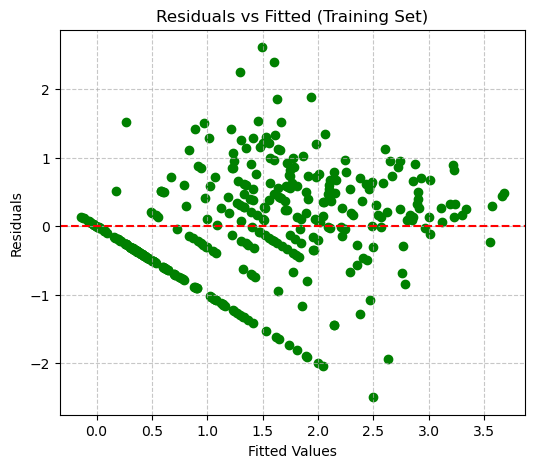

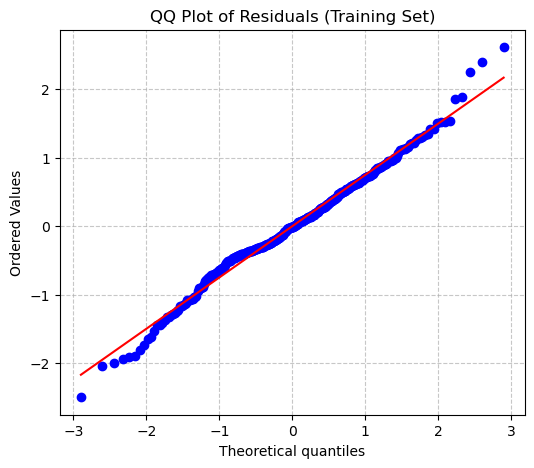

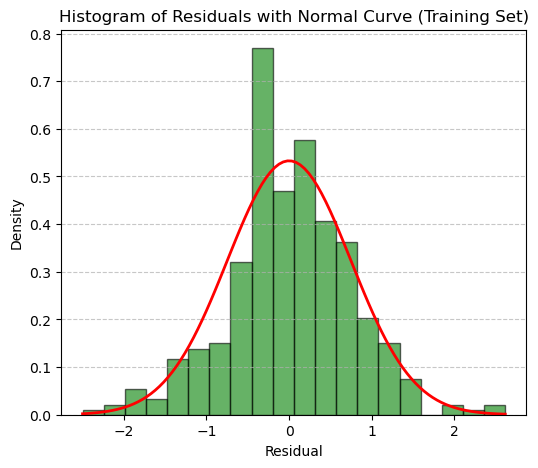

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import norm

# Calculate fitted values and residuals
fitted_vals = result.fittedvalues
residuals = df_final["Dass_Long"] - fitted_vals

# Store in dataframe
df_final["Fitted"] = fitted_vals
df_final["Residual"] = residuals

# 1. Residuals vs Fitted plot
plt.figure(figsize=(6, 5))
plt.scatter(df_final["Fitted"], df_final["Residual"], color="green")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Training Set)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 2. QQ plot of residuals
plt.figure(figsize=(6, 5))
stats.probplot(df_final["Residual"], dist="norm", plot=plt)
plt.title("QQ Plot of Residuals (Training Set)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 3. Histogram of residuals with normal curve
mu, std = np.mean(residuals), np.std(residuals)

plt.figure(figsize=(6, 5))
count, bins, ignored = plt.hist(residuals, bins=20, density=True,
                                 edgecolor='black', alpha=0.6, color='green')

x = np.linspace(min(bins), max(bins), 100)
plt.plot(x, norm.pdf(x, mu, std), 'r', linewidth=2)

plt.title("Histogram of Residuals with Normal Curve (Training Set)")
plt.xlabel("Residual")
plt.ylabel("Density")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [54]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# ----------------------------------------
# 1. Setup
# ----------------------------------------
df = adults_filled.copy()

# ----------------------------------------
# 2. Melt timestamps into long format
# ----------------------------------------
time_cols = [f"Session {i}" for i in range(1, 37)]
df_times = df[["ID"] + time_cols].melt(id_vars="ID", var_name="Session", value_name="Timestamp")
df_times["SessionNum"] = df_times["Session"].str.extract("(\d+)").astype(int)
df_times["Timestamp"] = df_times["Timestamp"].astype(str).str.strip()
df_times["Timestamp"] = df_times["Timestamp"].replace(["0", "", "nan", "NaT", "None"], pd.NA)
df_times["Timestamp"] = pd.to_datetime(df_times["Timestamp"], errors="coerce")
df_times = df_times.dropna(subset=["Timestamp"])

# ----------------------------------------
# 3. Compute Days_Since_First
# ----------------------------------------
df_times = df_times.sort_values(by=["ID", "Timestamp"])
df_times["First_Session_Timestamp"] = df_times.groupby("ID")["Timestamp"].transform("min")
df_times["Days_Since_First"] = (df_times["Timestamp"] - df_times["First_Session_Timestamp"]).dt.days

# Keep only what we need
df_session_days = df_times[["ID", "SessionNum", "Days_Since_First"]]

# ----------------------------------------
# 4. Prepare DASS long format
# ----------------------------------------
df_dass = pd.concat([
    df.assign(Timepoint="Baseline", Dass_Long=df["DASSBaseline_log"]),
    df.assign(Timepoint="Week6", Dass_Long=df["DASSWeek6_log"]),
    df.assign(Timepoint="PostIntervention", Dass_Long=df["DASSPost_log"]),
], ignore_index=True)

df_dass = df_dass[[
    "ID", "Timepoint", "Dass_Long", "Last_Intervention_Score", "ActivePassive",
    "Mid_Intervention_Score", "SalivaBaseline_log", "AnxietyBaseline_log", "BloodBaseline_log"
]]

# ----------------------------------------
# 5. Assign closest session by day offset (0, 42, 84)
# ----------------------------------------
# First, merge all session data into one (days since first per ID+session)
def get_closest_session(group, target_day):
    group["Diff"] = abs(group["Days_Since_First"] - target_day)
    return group.loc[group["Diff"].idxmin()]

closest_baseline = df_session_days.groupby("ID").apply(get_closest_session, target_day=0).reset_index(drop=True)
closest_week6 = df_session_days.groupby("ID").apply(get_closest_session, target_day=42).reset_index(drop=True)
closest_week12 = df_session_days.groupby("ID").apply(get_closest_session, target_day=84).reset_index(drop=True)

closest_baseline["Timepoint"] = "Baseline"
closest_week6["Timepoint"] = "Week6"
closest_week12["Timepoint"] = "PostIntervention"

df_timepoints = pd.concat([closest_baseline, closest_week6, closest_week12], ignore_index=True)

# ----------------------------------------
# 6. Merge to assign Days_Since_First to each DASS row
# ----------------------------------------
df_final = pd.merge(df_dass, df_timepoints, on=["ID", "Timepoint"], how="left")

# ----------------------------------------
# 7. Fit Mixed Effects Model
# ----------------------------------------
model = smf.mixedlm(
    "Dass_Long ~ Timepoint + C(ActivePassive) + AnxietyBaseline_log +  Mid_Intervention_Score + Last_Intervention_Score",
    df_final,
    groups=df_final["ID"]
)
result = model.fit()
print(result.summary())

                 Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      Dass_Long
No. Observations:        366          Method:                  REML     
No. Groups:              122          Scale:                   0.7018   
Min. group size:         3            Log-Likelihood:          -518.7464
Max. group size:         3            Converged:               Yes      
Mean group size:         3.0                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.700    0.424  1.650 0.099 -0.132  1.531
Timepoint[T.PostIntervention] -0.440    0.107 -4.105 0.000 -0.651 -0.230
Timepoint[T.Week6]            -0.107    0.107 -0.993 0.321 -0.317  0.104
C(ActivePassive)[T.Passive]   -0.102    0.199 -0.514 0.608 -0.491  0.

In [55]:
# Variance of fixed effects predictions
y_fixed = result.fittedvalues  # Predictions using fixed effects
var_fixed = np.var(y_fixed)

# Residual (within-group) variance
var_resid = result.scale

# Random effect variance (between-group)
var_random = result.cov_re.iloc[0, 0]

# Marginal R²: fixed / total
r2_marginal = var_fixed / (var_fixed + var_random + var_resid)

# Conditional R²: (fixed + random) / total
r2_conditional = (var_fixed + var_random) / (var_fixed + var_random + var_resid)

print(f"Marginal R² (fixed effects only): {r2_marginal:.3f}")
print(f"Conditional R² (fixed + random effects): {r2_conditional:.3f}")

Marginal R² (fixed effects only): 0.432
Conditional R² (fixed + random effects): 0.614


# Saliva Cortisol

In [59]:
# 2. Rename columns
adults_filled = adults_filled.rename(columns={
    "Last Intervention Score": "Last_Intervention_Score",
    "Active/Passive":  "ActivePassive",
    "Mid Intervention Score": "Mid_Intervention_Score",
    "Blood Cortisol Baseline": "Blood_Cortisol_Baseline",
    "Anxiety_Baseline": "Anxiety_Baseline",
    "Anxiety_Week 6": "Anxiety_Week_6",
    "Anxiety_Week 12": "Anxiety_Week_12",
    "Stress_Baseline": "Stress_Baseline",
    "Stress_Week 6": "Stress_Week_6",
    "Stress_Week 12": "Stress_Week_12",
    "DASS Baseline": "DASS_Baseline"

})

# Log Transformed

In [60]:
import numpy as np

# Assuming your DataFrame is called df and the column to transform is 'your_variable'
adults_filled['BloodBaseline_log'] = np.log(adults_filled['Blood_Cortisol_Baseline'] + 1)
adults_filled['BloodPost_log'] = np.log(adults_filled['Blood Cortisol Intervention'] + 1)
adults_filled['SalivaBaseline_log'] = np.log(adults_filled['Saliva_Cortisol_Baseline'] + 1)
adults_filled['SalivaPost_log'] = np.log(adults_filled['Saliva Cortisol Intervention'] + 1)
adults_filled['AnxietyBaseline_log'] = np.log(adults_filled['Anxiety_Baseline'] + 1)
adults_filled['LastScore_log'] = np.log(adults_filled['Last_Intervention_Score'] + 1)
adults_filled['MidScore_log'] = np.log(adults_filled['Mid_Intervention_Score'] + 1)
adults_filled['DASSBaseline_log'] = np.log(adults_filled['DASS_Baseline'] + 1)
adults_filled['DASSWeek6_log'] = np.log(adults_filled['DASS_Week_6'] + 1)
adults_filled['DASSPost_log'] = np.log(adults_filled['DASS Week 12'] + 1)

In [61]:
import pandas as pd
import statsmodels.formula.api as smf

# Original dataset
df = adults_filled.copy()

# ----------------------------
# 1. Melt score and time columns
# ----------------------------
score_cols = [f"Session {i} Weighted Sum" for i in range(1, 37)]
time_cols = [f"Session {i}" for i in range(1, 37)]

# Melt scores
df_scores = df[["ID"] + score_cols].melt(id_vars="ID", var_name="Session", value_name="Score")
df_scores["SessionNum"] = df_scores["Session"].str.extract("(\d+)").astype(int)

# Melt times
df_times = df[["ID"] + time_cols].melt(id_vars="ID", var_name="Session", value_name="Timestamp")
df_times["SessionNum"] = df_times["Session"].str.extract("(\d+)").astype(int)
df_times["Timestamp"] = df_times["Timestamp"].astype(str).str.strip()
df_times["Timestamp"] = df_times["Timestamp"].replace(["0", "", "nan", "NaT", "None"], pd.NA)
df_times["Timestamp"] = pd.to_datetime(df_times["Timestamp"], errors="coerce")

# Merge scores and times
df_long_scores = pd.merge(df_scores, df_times, on=["ID", "SessionNum"])
df_long_scores = df_long_scores.dropna(subset=["Timestamp"])  # drop missing timestamps

# ----------------------------
# 2. Create long-format cortisol data
# ----------------------------
df_cortisol = pd.concat([
    df.assign(Timepoint="Baseline", SalivaCortisol_Long=df["SalivaBaseline_log"]),
    df.assign(Timepoint="PostIntervention", SalivaCortisol_Long=df["SalivaPost_log"])
], ignore_index=True)

df_cortisol = df_cortisol[[
    "ID", "Timepoint", "SalivaCortisol_Long", "Last_Intervention_Score", "ActivePassive",
    "Mid_Intervention_Score", "BloodBaseline_log",  "DASSBaseline_log"
]]

# ----------------------------
# 3. Merge cortisol + session timeline data (optional)
# ----------------------------
# If you want to model with session timing as a variable, merge it; else skip
df_final = pd.merge(df_cortisol, df_long_scores[["ID", "Timestamp"]].drop_duplicates("ID"), on="ID", how="left")

# ----------------------------
# 4. Mixed effects model
# ----------------------------
model = smf.mixedlm(
    "SalivaCortisol_Long ~ Timepoint + C(ActivePassive) + Mid_Intervention_Score + Last_Intervention_Score +  BloodBaseline_log",
    df_final,
    groups=df_final["ID"],
    re_formula="~Timepoint"
)
result = model.fit()
print(result.summary())

                       Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       SalivaCortisol_Long
No. Observations:        244           Method:                   REML               
No. Groups:              122           Scale:                    0.2062             
Min. group size:         2             Log-Likelihood:           -245.7964          
Max. group size:         2             Converged:                Yes                
Mean group size:         2.0                                                        
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                 -0.447    0.319 -1.399 0.162 -1.073  0.179
Timepoint[T.PostIntervention]              0.573    0.067  8.510 0.000  0.441  0.706
C(Ac

In [62]:
# Variance of fixed effects predictions
y_fixed = result.fittedvalues  # Predictions using fixed effects
var_fixed = np.var(y_fixed)

# Residual (within-group) variance
var_resid = result.scale

# Random effect variance (between-group)
var_random = result.cov_re.iloc[0, 0]

# Marginal R²: fixed / total
r2_marginal = var_fixed / (var_fixed + var_random + var_resid)

# Conditional R²: (fixed + random) / total
r2_conditional = (var_fixed + var_random) / (var_fixed + var_random + var_resid)

print(f"Marginal R² (fixed effects only): {r2_marginal:.3f}")
print(f"Conditional R² (fixed + random effects): {r2_conditional:.3f}")

Marginal R² (fixed effects only): 0.758
Conditional R² (fixed + random effects): 0.881


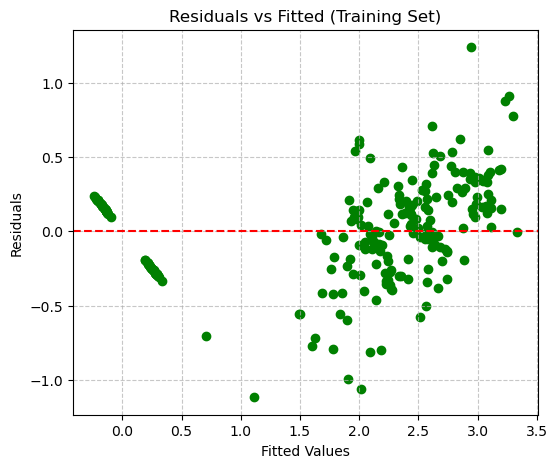

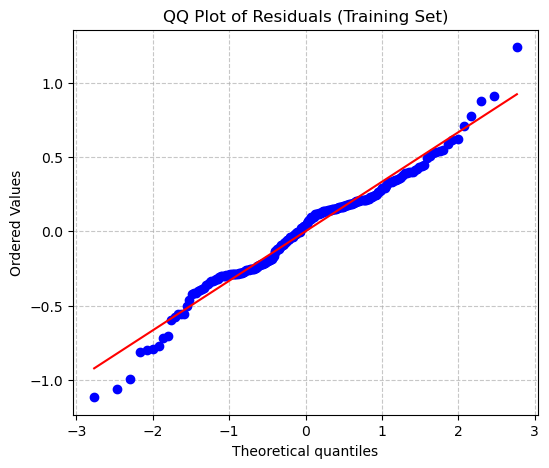

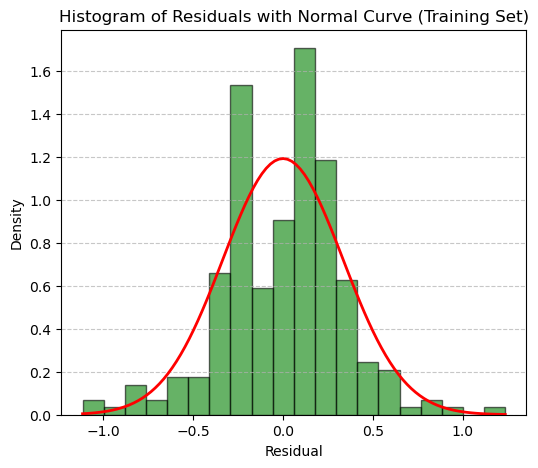

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import norm

# Calculate fitted values and residuals
fitted_vals = result.fittedvalues
residuals = df_final["SalivaCortisol_Long"] - fitted_vals

# Store in dataframe
df_final["Fitted"] = fitted_vals
df_final["Residual"] = residuals

# 1. Residuals vs Fitted plot
plt.figure(figsize=(6, 5))
plt.scatter(df_final["Fitted"], df_final["Residual"], color="green")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Training Set)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 2. QQ plot of residuals
plt.figure(figsize=(6, 5))
stats.probplot(df_final["Residual"], dist="norm", plot=plt)
plt.title("QQ Plot of Residuals (Training Set)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 3. Histogram of residuals with normal curve
mu, std = np.mean(residuals), np.std(residuals)

plt.figure(figsize=(6, 5))
count, bins, ignored = plt.hist(residuals, bins=20, density=True,
                                 edgecolor='black', alpha=0.6, color='green')

x = np.linspace(min(bins), max(bins), 100)
plt.plot(x, norm.pdf(x, mu, std), 'r', linewidth=2)

plt.title("Histogram of Residuals with Normal Curve (Training Set)")
plt.xlabel("Residual")
plt.ylabel("Density")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [64]:
import pandas as pd
import statsmodels.formula.api as smf

# Original dataset
df = adults_filled.copy()

# ----------------------------
# 1. Melt score and time columns
# ----------------------------
score_cols = [f"Session {i} Weighted Sum" for i in range(1, 37)]
time_cols = [f"Session {i}" for i in range(1, 37)]

# Melt scores
df_scores = df[["ID"] + score_cols].melt(id_vars="ID", var_name="Session", value_name="Score")
df_scores["SessionNum"] = df_scores["Session"].str.extract("(\d+)").astype(int)

# Melt times
df_times = df[["ID"] + time_cols].melt(id_vars="ID", var_name="Session", value_name="Timestamp")
df_times["SessionNum"] = df_times["Session"].str.extract("(\d+)").astype(int)
df_times["Timestamp"] = df_times["Timestamp"].astype(str).str.strip()
df_times["Timestamp"] = df_times["Timestamp"].replace(["0", "", "nan", "NaT", "None"], pd.NA)
df_times["Timestamp"] = pd.to_datetime(df_times["Timestamp"], errors="coerce")

# Merge scores and times
df_long_scores = pd.merge(df_scores, df_times, on=["ID", "SessionNum"])
df_long_scores = df_long_scores.dropna(subset=["Timestamp"])  # drop missing timestamps

# ----------------------------
# 2. Create long-format cortisol data
# ----------------------------
df_cortisol = pd.concat([
    df.assign(Timepoint="Baseline", SalivaCortisol_Long=df["SalivaBaseline_log"]),
    df.assign(Timepoint="PostIntervention", SalivaCortisol_Long=df["SalivaPost_log"])
], ignore_index=True)

df_cortisol = df_cortisol[[
    "ID", "Timepoint", "SalivaCortisol_Long", "Last_Intervention_Score", "ActivePassive",
    "Mid_Intervention_Score", "BloodBaseline_log",  "DASSBaseline_log"
]]

# ----------------------------
# 3. Merge cortisol + session timeline data (optional)
# ----------------------------
# If you want to model with session timing as a variable, merge it; else skip
df_final = pd.merge(df_cortisol, df_long_scores[["ID", "Timestamp"]].drop_duplicates("ID"), on="ID", how="left")

# ----------------------------
# 4. Mixed effects model
# ----------------------------
model = smf.mixedlm(
    "SalivaCortisol_Long ~ Timepoint + C(ActivePassive) +  Last_Intervention_Score + Mid_Intervention_Score + BloodBaseline_log",
    df_final,
    groups=df_final["ID"]
)
result = model.fit()
print(result.summary())

                 Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   SalivaCortisol_Long
No. Observations:    244       Method:               REML               
No. Groups:          122       Scale:                0.2770             
Min. group size:     2         Log-Likelihood:       -245.7981          
Max. group size:     2         Converged:            Yes                
Mean group size:     2.0                                                
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     -0.450    0.318 -1.413 0.158 -1.073  0.174
Timepoint[T.PostIntervention]  0.573    0.067  8.510 0.000  0.441  0.706
C(ActivePassive)[T.Passive]    0.149    0.142  1.048 0.295 -0.129  0.427
Last_Intervention_Score       -0.017    0.010 -1.674 0.094 -0.036  0.

In [65]:
# Variance of fixed effects predictions
y_fixed = result.fittedvalues  # Predictions using fixed effects
var_fixed = np.var(y_fixed)

# Residual (within-group) variance
var_resid = result.scale

# Random effect variance (between-group)
var_random = result.cov_re.iloc[0, 0]

# Marginal R²: fixed / total
r2_marginal = var_fixed / (var_fixed + var_random + var_resid)

# Conditional R²: (fixed + random) / total
r2_conditional = (var_fixed + var_random) / (var_fixed + var_random + var_resid)

print(f"Marginal R² (fixed effects only): {r2_marginal:.3f}")
print(f"Conditional R² (fixed + random effects): {r2_conditional:.3f}")

Marginal R² (fixed effects only): 0.750
Conditional R² (fixed + random effects): 0.836


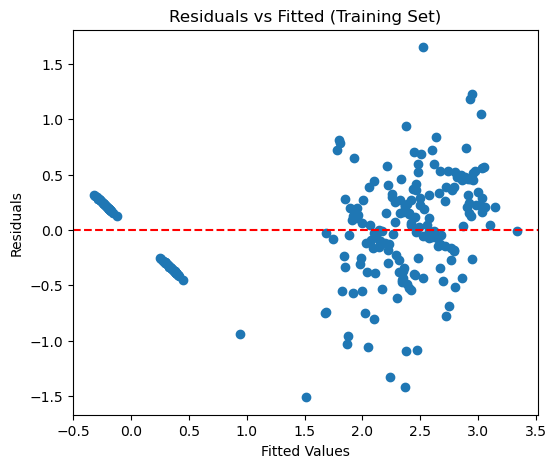

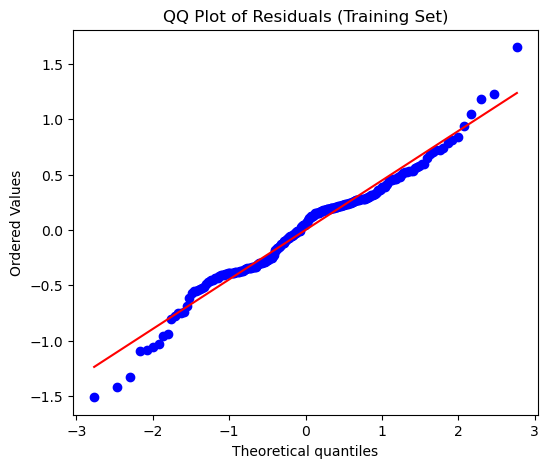

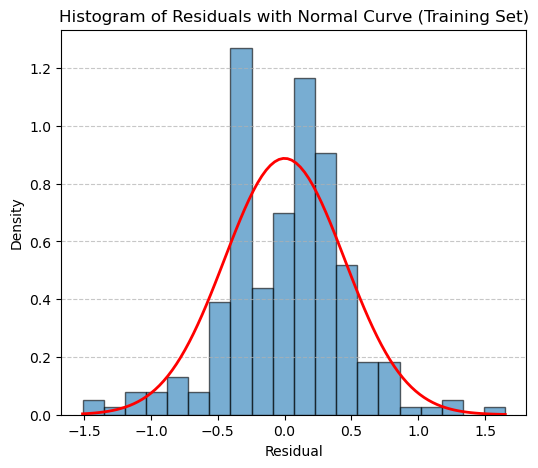

In [66]:
# Predicted values on training data (fitted values)
fitted_vals = result.fittedvalues

# Residuals = Actual - Fitted
residuals = df_final["SalivaCortisol_Long"] - fitted_vals

df_final["Fitted"] = fitted_vals
df_final["Residual"] = residuals

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_final["Fitted"], df_final["Residual"])
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Training Set)")
plt.show()

import scipy.stats as stats

plt.figure(figsize=(6, 5))
stats.probplot(df_final["Residual"], dist="norm", plot=plt)
plt.title("QQ Plot of Residuals (Training Set)")
plt.show()

from scipy.stats import norm

# Get mean and std of residuals
mu, std = np.mean(residuals), np.std(residuals)

# Plot histogram
plt.figure(figsize=(6, 5))
count, bins, ignored = plt.hist(residuals, bins=20, density=True, edgecolor='black', alpha=0.6)

# Plot normal distribution curve
x = np.linspace(min(bins), max(bins), 100)
plt.plot(x, norm.pdf(x, mu, std), 'r', linewidth=2)

# Labels and title
plt.title("Histogram of Residuals with Normal Curve (Training Set)")
plt.xlabel("Residual")
plt.ylabel("Density")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Other Mixed Models 

In [48]:
df_final

,ID,Timepoint,BloodCortisol_Long,Last_Intervention_Score,ActivePassive,Mid_Intervention_Score,SalivaBaseline_log,DASSBaseline_log,Timestamp
0,1,Baseline,3.408305,10.0,Active,26.0,1.295275,3.465736,2022-04-20 14:00:00
1,2,Baseline,3.526272,16.0,Active,19.0,1.278152,3.218876,2022-04-20 12:35:00
2,4,Baseline,0.000000,12.0,Active,17.0,0.000000,1.945910,2022-04-19 12:55:00
3,5,Baseline,2.628718,12.0,Active,25.0,2.122022,2.079442,2022-04-21 12:35:00
4,6,Baseline,3.748963,17.0,Active,24.0,0.989541,3.367296,2022-04-20 13:40:00
...,...,...,...,...,...,...,...,...,...
239,216,PostIntervention,3.440899,21.0,Passive,22.0,1.994700,2.197225,2022-06-02 11:00:00
240,217,PostIntervention,3.843423,31.0,Passive,23.0,2.090629,2.197225,2022-06-02 10:35:00
241,220,PostIntervention,0.000000,22.0,Passive,24.0,0.000000,2.302585,2022-06-02 10:28:00
242,221,PostIntervention,3.593717,27.0,Passive,21.0,2.504301,0.693147,2022-06-14 17:55:00


In [47]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GroupShuffleSplit
from merf import MERF

# -----------------------
# 1) Use your dataset
# -----------------------
df = df_final.copy()

# -----------------------
# 2) Prepare predictors
# -----------------------
predictor_cols = [
    "SalivaBaseline_log",
    "DASSBaseline_log",
    "Mid_Intervention_Score",
    "Last_Intervention_Score",
    "ActivePassive"  # categorical predictor
]

# One-hot encode the categorical variable (drop_first=True avoids dummy trap)
df_encoded = pd.get_dummies(df[predictor_cols], columns=["ActivePassive"], drop_first=True)

# Cluster ID (random effect grouping)
clusters = df["ID"]  # keep as Series

# Random-effect design: random intercept only
Z = pd.DataFrame({"Intercept": 1}, index=df.index)

# Dependent variable
y = df["BloodCortisol_Long"]

# -----------------------
# 3) Train/test split — group-wise
# -----------------------
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df_encoded, y, groups=clusters))

X_train, X_test = df_encoded.iloc[train_idx], df_encoded.iloc[test_idx]
Z_train, Z_test = Z.iloc[train_idx], Z.iloc[test_idx]
clusters_train, clusters_test = clusters.iloc[train_idx], clusters.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# -----------------------
# 4) MERF model
# -----------------------
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
merf = MERF(fixed_effects_model=rf, max_iterations=20)

# -----------------------
# 5) Fit and predict
# -----------------------
merf.fit(X_train, Z_train, clusters_train, y_train)
y_pred = merf.predict(X_test, Z_test, clusters_test)

# -----------------------
# 6) Evaluate
# -----------------------
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test R²:", r2_score(y_test, y_pred))

# -----------------------
# 7) Feature importance
# -----------------------
importances = merf.fe_model.feature_importances_
for col, imp in zip(df_encoded.columns, importances):
    print(f"{col}: {imp:.3f}")

INFO     [merf.py:307] Training GLL is -257.9381482965836 at iteration 1.
INFO     [merf.py:307] Training GLL is -457.5875855094465 at iteration 2.
INFO     [merf.py:307] Training GLL is -571.3432853070506 at iteration 3.
INFO     [merf.py:307] Training GLL is -629.6519332324468 at iteration 4.
INFO     [merf.py:307] Training GLL is -667.2787959466957 at iteration 5.
INFO     [merf.py:307] Training GLL is -699.8922360987909 at iteration 6.
INFO     [merf.py:307] Training GLL is -728.3273617070608 at iteration 7.
INFO     [merf.py:307] Training GLL is -753.4355919071353 at iteration 8.
INFO     [merf.py:307] Training GLL is -774.508688240557 at iteration 9.
INFO     [merf.py:307] Training GLL is -792.3979712424905 at iteration 10.
INFO     [merf.py:307] Training GLL is -807.6046691439099 at iteration 11.
INFO     [merf.py:307] Training GLL is -821.0284444189872 at iteration 12.
INFO     [merf.py:307] Training GLL is -833.2410887076784 at iteration 13.
INFO     [merf.py:307] Training GLL

Test RMSE: 0.45449040323427276
Test R²: 0.9272539384538308
SalivaBaseline_log: 0.923
DASSBaseline_log: 0.012
Mid_Intervention_Score: 0.021
Last_Intervention_Score: 0.012
ActivePassive_Passive: 0.032


In [56]:
df_final

,ID,Timepoint,Dass_Long,Last_Intervention_Score,ActivePassive,Mid_Intervention_Score,SalivaBaseline_log,AnxietyBaseline_log,BloodBaseline_log,SessionNum,Days_Since_First,Diff
0,1,Baseline,3.465736,10.0,Active,26.0,1.295275,2.442347,3.408305,1,0,0
1,2,Baseline,3.218876,16.0,Active,19.0,1.278152,2.397895,3.526272,1,0,0
2,4,Baseline,1.945910,12.0,Active,17.0,0.000000,1.386294,0.000000,1,0,0
3,5,Baseline,2.079442,12.0,Active,25.0,2.122022,1.791759,2.628718,1,0,0
4,6,Baseline,3.367296,17.0,Active,24.0,0.989541,2.397895,3.748963,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
361,216,PostIntervention,2.772589,21.0,Passive,22.0,1.994700,1.098612,2.601059,23,84,0
362,217,PostIntervention,0.693147,31.0,Passive,23.0,2.090629,0.000000,3.136928,23,85,1
363,220,PostIntervention,0.000000,22.0,Passive,24.0,0.000000,0.405465,0.000000,15,82,2
364,221,PostIntervention,0.000000,27.0,Passive,21.0,2.504301,0.693147,2.814510,12,62,22


In [58]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GroupShuffleSplit
from merf import MERF

# -----------------------
# 1) Use your dataset
# -----------------------
df = df_final.copy()

# -----------------------
# 2) Prepare predictors
# -----------------------
predictor_cols = [
    "SalivaBaseline_log",
    "BloodBaseline_log",
    "Days_Since_First",
    "Mid_Intervention_Score",
    "Last_Intervention_Score",
    "ActivePassive"  # categorical predictor
]

# One-hot encode the categorical variable (drop_first=True avoids dummy trap)
df_encoded = pd.get_dummies(df[predictor_cols], columns=["ActivePassive"], drop_first=True)

# Cluster ID (random effect grouping)
clusters = df["ID"]  # keep as Series

# Random-effect design: random intercept only
Z = pd.DataFrame({"Intercept": 1}, index=df.index)

# Dependent variable
y = df["Dass_Long"]

# -----------------------
# 3) Train/test split — group-wise
# -----------------------
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df_encoded, y, groups=clusters))

X_train, X_test = df_encoded.iloc[train_idx], df_encoded.iloc[test_idx]
Z_train, Z_test = Z.iloc[train_idx], Z.iloc[test_idx]
clusters_train, clusters_test = clusters.iloc[train_idx], clusters.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# -----------------------
# 4) MERF model
# -----------------------
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
merf = MERF(fixed_effects_model=rf, max_iterations=20)

# -----------------------
# 5) Fit and predict
# -----------------------
merf.fit(X_train, Z_train, clusters_train, y_train)
y_pred = merf.predict(X_test, Z_test, clusters_test)

# -----------------------
# 6) Evaluate
# -----------------------
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test R²:", r2_score(y_test, y_pred))

# -----------------------
# 7) Feature importance
# -----------------------
importances = merf.fe_model.feature_importances_
for col, imp in zip(df_encoded.columns, importances):
    print(f"{col}: {imp:.3f}")

INFO     [merf.py:307] Training GLL is -293.7614312682694 at iteration 1.
INFO     [merf.py:307] Training GLL is -421.02152394216233 at iteration 2.
INFO     [merf.py:307] Training GLL is -436.566504421227 at iteration 3.
INFO     [merf.py:307] Training GLL is -434.6864115859041 at iteration 4.
INFO     [merf.py:307] Training GLL is -432.54900033985297 at iteration 5.
INFO     [merf.py:307] Training GLL is -432.92523350811564 at iteration 6.
INFO     [merf.py:307] Training GLL is -433.7661477096582 at iteration 7.
INFO     [merf.py:307] Training GLL is -434.01840042605534 at iteration 8.
INFO     [merf.py:307] Training GLL is -434.63290141160536 at iteration 9.
INFO     [merf.py:307] Training GLL is -435.32487978075835 at iteration 10.
INFO     [merf.py:307] Training GLL is -436.8215489693818 at iteration 11.
INFO     [merf.py:307] Training GLL is -436.2116011296665 at iteration 12.
INFO     [merf.py:307] Training GLL is -438.93306547729713 at iteration 13.
INFO     [merf.py:307] Train

Test RMSE: 1.2701582383764916
Test R²: 0.1463830904144704
SalivaBaseline_log: 0.164
BloodBaseline_log: 0.281
Days_Since_First: 0.209
Mid_Intervention_Score: 0.126
Last_Intervention_Score: 0.191
ActivePassive_Passive: 0.029


In [67]:
df_final

,ID,Timepoint,SalivaCortisol_Long,Last_Intervention_Score,ActivePassive,Mid_Intervention_Score,BloodBaseline_log,DASSBaseline_log,Timestamp,Fitted,Residual
0,1,Baseline,1.295275,10.0,Active,26.0,3.408305,3.465736,2022-04-20 14:00:00,2.096595,-0.801320
1,2,Baseline,1.278152,16.0,Active,19.0,3.526272,3.218876,2022-04-20 12:35:00,2.025951,-0.747798
2,4,Baseline,0.000000,12.0,Active,17.0,0.000000,1.945910,2022-04-19 12:55:00,-0.258135,0.258135
3,5,Baseline,2.122022,12.0,Active,25.0,2.628718,2.079442,2022-04-21 12:35:00,1.845829,0.276193
4,6,Baseline,0.989541,17.0,Active,24.0,3.748963,3.367296,2022-04-20 13:40:00,2.047024,-1.057482
...,...,...,...,...,...,...,...,...,...,...,...
239,216,PostIntervention,3.007414,21.0,Passive,22.0,2.601059,2.197225,2022-06-02 11:00:00,2.480362,0.527052
240,217,PostIntervention,2.724973,31.0,Passive,23.0,3.136928,2.197225,2022-06-02 10:35:00,2.531745,0.193228
241,220,PostIntervention,0.000000,22.0,Passive,24.0,0.000000,2.302585,2022-06-02 10:28:00,0.390623,-0.390623
242,221,PostIntervention,1.981553,27.0,Passive,21.0,2.814510,0.693147,2022-06-14 17:55:00,2.353817,-0.372264


In [68]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GroupShuffleSplit
from merf import MERF

# -----------------------
# 1) Use your dataset
# -----------------------
df = df_final.copy()

# -----------------------
# 2) Prepare predictors
# -----------------------
predictor_cols = [
    "DASSBaseline_log",
    "BloodBaseline_log",
    "Mid_Intervention_Score",
    "Last_Intervention_Score",
    "ActivePassive"  # categorical predictor
]

# One-hot encode the categorical variable (drop_first=True avoids dummy trap)
df_encoded = pd.get_dummies(df[predictor_cols], columns=["ActivePassive"], drop_first=True)

# Cluster ID (random effect grouping)
clusters = df["ID"]  # keep as Series

# Random-effect design: random intercept only
Z = pd.DataFrame({"Intercept": 1}, index=df.index)

# Dependent variable
y = df["SalivaCortisol_Long"]

# -----------------------
# 3) Train/test split — group-wise
# -----------------------
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df_encoded, y, groups=clusters))

X_train, X_test = df_encoded.iloc[train_idx], df_encoded.iloc[test_idx]
Z_train, Z_test = Z.iloc[train_idx], Z.iloc[test_idx]
clusters_train, clusters_test = clusters.iloc[train_idx], clusters.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# -----------------------
# 4) MERF model
# -----------------------
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
merf = MERF(fixed_effects_model=rf, max_iterations=20)

# -----------------------
# 5) Fit and predict
# -----------------------
merf.fit(X_train, Z_train, clusters_train, y_train)
y_pred = merf.predict(X_test, Z_test, clusters_test)

# -----------------------
# 6) Evaluate
# -----------------------
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test R²:", r2_score(y_test, y_pred))

# -----------------------
# 7) Feature importance
# -----------------------
importances = merf.fe_model.feature_importances_
for col, imp in zip(df_encoded.columns, importances):
    print(f"{col}: {imp:.3f}")

INFO     [merf.py:307] Training GLL is -135.71280935328954 at iteration 1.
INFO     [merf.py:307] Training GLL is -243.56108549946455 at iteration 2.
INFO     [merf.py:307] Training GLL is -308.0316587833595 at iteration 3.
INFO     [merf.py:307] Training GLL is -351.93712650091237 at iteration 4.
INFO     [merf.py:307] Training GLL is -384.9846860974993 at iteration 5.
INFO     [merf.py:307] Training GLL is -411.23168031187515 at iteration 6.
INFO     [merf.py:307] Training GLL is -432.4763576962944 at iteration 7.
INFO     [merf.py:307] Training GLL is -450.2522786741926 at iteration 8.
INFO     [merf.py:307] Training GLL is -465.53277605620957 at iteration 9.
INFO     [merf.py:307] Training GLL is -478.8584354833086 at iteration 10.
INFO     [merf.py:307] Training GLL is -490.6702201608494 at iteration 11.
INFO     [merf.py:307] Training GLL is -501.2549799922547 at iteration 12.
INFO     [merf.py:307] Training GLL is -510.88853876998695 at iteration 13.
INFO     [merf.py:307] Train

Test RMSE: 0.6268865804610417
Test R²: 0.7706703470043457
DASSBaseline_log: 0.052
BloodBaseline_log: 0.868
Mid_Intervention_Score: 0.041
Last_Intervention_Score: 0.035
ActivePassive_Passive: 0.004
